### [`1. Python多因子选股策略实践`](https://datawhalechina.github.io/whale-quant/#/./ch04_%E9%87%8F%E5%8C%96%E9%80%89%E8%82%A1%E7%AD%96%E7%95%A5/ch04_%E9%87%8F%E5%8C%96%E9%80%89%E8%82%A1%E7%AD%96%E7%95%A5?id=_45-python%e5%a4%9a%e5%9b%a0%e5%ad%90%e9%80%89%e8%82%a1%e7%ad%96%e7%95%a5%e5%ae%9e%e8%b7%b5)

多因子选股模型是一个用来选择股票投资组合的策略，它考虑了多个与预期收益相关的因子。这种模型的理念基于这样的理论：单一因子可能无法全面捕捉到市场的所有变化，而多个因子的组合可以提供更全面、更稳定的预测。

多因子选股模型的核心思想是通过多个因子的组合来选择股票，因子可以通过历史数据来计算，然后用来预测未来的股票表现，以期获取更全面、更稳定的预测。这些因子可以包括基本面因子、技术分析因子、宏观经济因子等。例如：

- `基本面因子`：包括市盈率（PE）、市净率（PB）、营业收入增长率等
- `技术分析因子`：包括动量（Momentum）、波动率（Volatility）等
- `宏观经济因子`：包括利率、通货膨胀率等

在实现多因子选股模型时，需要进行以下步骤：

- `确定目标和约束条件`: 明确多因子模型要达到的投资目标收益率、风险水平等要求。同时考虑实际的投资约束,例如组合数目限制、行业比例限制等。

- `选择因子并计算`: 根据目标和约束条件,选择合适的股票因子,如 PE, PB 等。收集数据计算得到每只股票的各因子值。

- `异常值处理`: 检查数据中的异常值和错报数据,进行处理和滤除,保证因子值的质量。

- `因子标准化`: 因为不同因子的取值范围差异很大,需要进行标准化处理,例如去均值和缩放等。

- `确定因子权重`: 根据因子的重要性给予不同权重,通常通过统计方法比如主成分分析来确定。

- `构建多因子模型`: 结合因子值和权重,建立多因子评分模型,得到各股票的综合评分。

- `股票筛选和组合优化`: 根据评分进行股票筛选,并进行组合优化,获得符合目标和约束条件的优化组合。

- `回测和调整模型`: 使用历史数据回测多因子模型的效果,根据结果进行调整和改进。


### [`2. 【手把手教你】Python量化Fama-French三因子模型`](https://www.shangyexinzhi.com/article/391399.html)


In [1]:
from pylab import mpl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib as mpl
import datetime
import time
sns.set()

# 正常显示画图时出现的中文和负号
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Arial Unicode MS'

In [2]:
from db_client import PostgreSQLClient, DBOperations
from data_api import TSDataAPI
from calc_factor import cal_smb_hml

In [3]:
postgresql_client = PostgreSQLClient()
pro = TSDataAPI().pro

In [13]:
# query = """
# SELECT DISTINCT trade_date
# FROM basic_daily
# ORDER BY trade_date ASC;
# """

query = """
SELECT 
    t1.trade_date,
	t1.ts_code,
	t1.pct_chg,
    t2.circ_mv,
	t2.pb
FROM stock_daily t1
INNER JOIN basic_daily t2
ON t1.trade_date = t2.trade_date AND t1.ts_code = t2.ts_code
WHERE t1.trade_date BETWEEN '20170101' AND '20190110'
ORDER BY t1.trade_date ASC;
"""

result = DBOperations.execute_query(postgresql_client, query)

In [14]:
# 1. select data from 20170101 - 20170131
# 2. merge daily based on trade_date, ts_code
# 3. [circ_mv, pb, pct_chg]

# df_stock_basic_merge = pd.DataFrame(
#     result,
#     columns=['trade_date', 'ts_code', 'pct_chg', 'circ_mv', 'pb']
# )
# df_stock_basic_merge['pct_chg'] = df_stock_basic_merge['pct_chg'].astype(
#     float)
# df_stock_basic_merge['circ_mv'] = df_stock_basic_merge['circ_mv'].astype(
#     float)
# df_stock_basic_merge['pb'] = df_stock_basic_merge['pb'].astype(
#     float)
# df_temp = df_stock_basic_merge.groupby('trade_date').apply(
#     cal_smb_hml
# ).to_frame()
# df_tfm = pd.DataFrame(
#     index=pd.to_datetime(df_temp.index),
#     data=np.array([[i[0][0], i[0][1]] for i in df_temp.values]),
#     columns=["SMB", "HML"]
# )
# df_tfm.to_csv('./data/df_three_factor_model.csv')

In [4]:
df_tfm = pd.read_csv('./data/df_three_factor_model.csv')
df_tfm.set_index(keys=['trade_date'], inplace=True)
df_tfm.index = pd.to_datetime(df_tfm.index)
df_tfm.head()

,SMB,HML
trade_date,,
2017-01-03,0.003141,0.003764
2017-01-04,0.000051,-0.006772
2017-01-05,-0.000475,0.003874
2017-01-06,-0.003580,0.007844
2017-01-09,0.000083,0.004125


In [5]:
df_tfm.tail(3)

,SMB,HML
trade_date,,
2019-01-08,0.001527,0.000237
2019-01-09,-0.004585,-0.002481
2019-01-10,0.003010,-0.003204


In [58]:
# 获取个股数据
stocks = {
    'wanke': '000002.SZ',
    'pingan': '601318.SH',
    'maotai': '600519.SH',
    'wanhua': '002415.SZ',
    'keda': '002230.SZ',
    'gzA': '399317.SZ',
}

start_date = '20170101'
end_date = '20190110'

stock_list = []
for stock, code in stocks.items():
    # if stock == 'gzA':
    #     f = pro.index_daily(
    #         ts_code=code,
    #         start_date=start_date,
    #         end_date=end_date
    #     )
    # else:
    #     f = pro.daily(
    #         ts_code=code,
    #         start_date=start_date,
    #         end_date=end_date
    #     )
    # f.to_csv(f"./data/{stock}.csv")
    f = pd.read_csv(f'./data/{stock}.csv', index_col=0)
    f['trade_date'] = f['trade_date'].astype(str)
    f.set_index(pd.to_datetime(f.trade_date), inplace=True)
    stock_list.append(f)

In [59]:
# 仅保留收益率数据，且用日期作为index
# 然后按照日期排序（增序）
for stock in stock_list:
    stock.index = pd.to_datetime(stock.trade_date)

df_stock = pd.concat([stock.pct_chg / 100 for stock in stock_list], axis=1)
df_stock.columns = ['wanke', 'pingan', 'maotai', 'wanhua', 'keda', 'gzA']
df_stock = df_stock.sort_index(ascending=True)
df_stock.head()
# 这里gzA是指国证A股指数，更能代表整个A股市场。

,wanke,pingan,maotai,wanhua,keda,gzA
trade_date,,,,,,
2017-01-03,0.0088,0.0071,0.0012,0.0181,0.0111,0.009550
2017-01-04,0.0058,-0.0008,0.0519,-0.0033,0.0230,0.009949
2017-01-05,0.0038,0.0022,-0.0147,0.0058,0.0036,0.000105
2017-01-06,-0.0139,-0.0081,0.0116,-0.0082,-0.0117,-0.006683
2017-01-09,0.0010,-0.0006,-0.0064,0.0066,0.0054,0.004816


In [60]:
# 整合数据，并简单探索
df = pd.merge(df_stock, df_tfm, left_index=True, right_index=True, how='inner')
df.isna().sum()
df = df.fillna(0)
rf = 1.032 ** (1/360) - 1
df = df - rf
df2 = df.copy()
df = df['20180101':]
df.head()

,wanke,pingan,maotai,wanhua,keda,gzA,SMB,HML
trade_date,,,,,,,,
2018-01-02,0.048212,0.037212,0.009012,0.003212,0.024112,0.012332,-0.005387,0.002752
2018-01-03,-0.007188,-0.022388,0.017012,0.012912,0.023512,0.007269,0.001037,-0.002175
2018-01-04,0.024312,0.002912,0.029512,0.021612,0.015112,0.003659,-0.008056,-0.004913
2018-01-05,0.049412,-0.004188,0.001712,-0.017888,-0.015788,0.001054,0.000346,0.006567
2018-01-08,0.035312,-0.012488,0.018512,0.025512,-0.011188,0.003654,-0.005741,0.002120


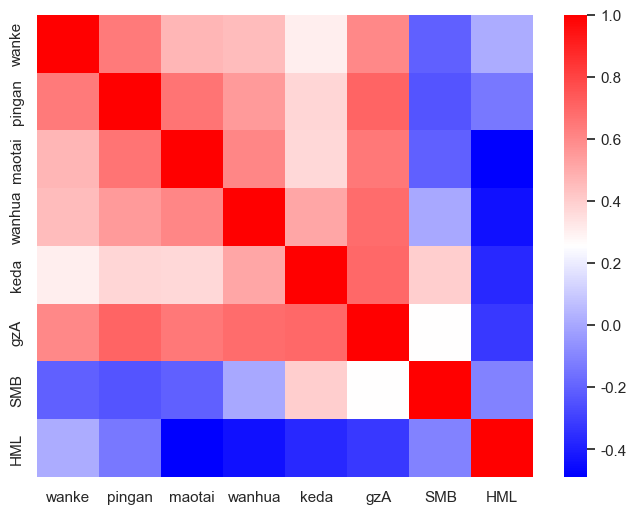

In [61]:
# 观察数据间的相关性
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), cmap='bwr')
plt.show()

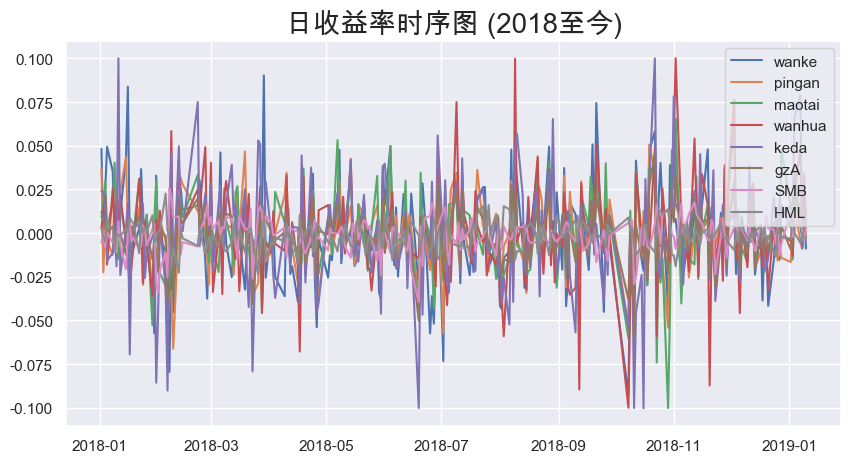

In [62]:
# 收益率时序图
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df[col], label=col)

plt.title('日收益率时序图 (2018至今)', fontsize=20)
plt.legend()
plt.show()

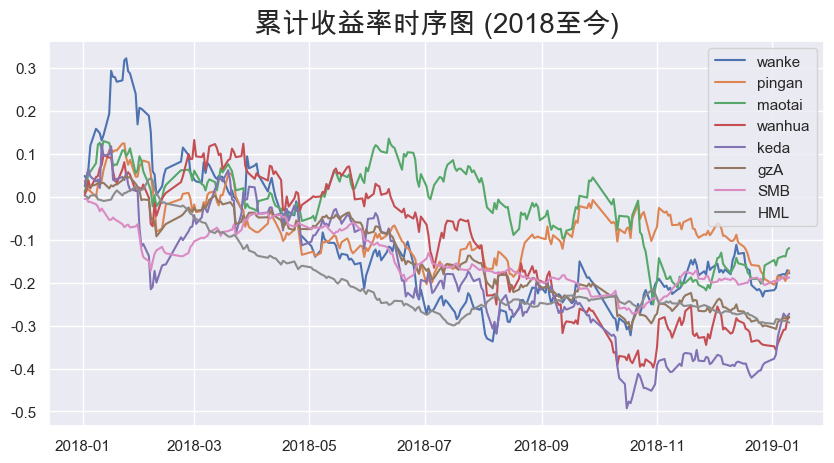

In [63]:
# 累计收益率时序图
plt.figure(figsize=(10, 5))

for col in df.columns:
    plt.plot((df[col] + 1).cumprod() - 1, label=col)

plt.title('累计收益率时序图 (2018至今)', fontsize=20)
plt.legend()
plt.show()

In [64]:
# 类似R语言的统计模型库statsmodels接口
import statsmodels.api as sm

stock_names = {
    'wanke': '万科A',
    'pingan': '中国平安',
    'maotai': '贵州茅台',
    'wanhua': '万华化学',
    'keda': '科大讯飞'
}

params = pd.DataFrame()

for stock in ['wanke', 'pingan', 'maotai', 'wanhua', 'keda']:
    model = sm.OLS(df[stock], sm.add_constant(
        df[['gzA', 'SMB', 'HML']].values))
    result = model.fit()
    params[stock_names[stock]] = result.params
    print(stock_names[stock] + '\n')
    print(result.summary())

万科A

                            OLS Regression Results                            
Dep. Variable:                  wanke   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     100.1
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           2.22e-42
Time:                        11:52:59   Log-Likelihood:                 652.71
No. Observations:                 250   AIC:                            -1297.
Df Residuals:                     246   BIC:                            -1283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.399    

### 结论

- 如果随机变量 X 与观测值 x 越一致，说明检验现象与零假设越接近，则越没有理由拒绝零假设。p 值 =0.05 意味着在原假设 H0（因子的预期收益率为零）下观测到比 x 更极端的收益（因子的预期收益率为 0，甚至为负收益）的条件概率为 5%；假如 p 值 =0.01，意味着在原假设 H0 下观测到比 x 更极端的收益的条件概率仅有 1%，也就是观测到“因子预期收益为零甚至为负”这个事件和原假设 H0 越不相符，因而越倾向于拒绝原假设。
- 因此，p 值帮助人们评估何时拒绝“因子的预期收益率为零”这个原假设。p 值越低，越倾向于拒绝原假设，越说明这个因子越有效。在学术界，p 值越低，因子越显著，研究成果越抢眼，越有可能得到更高的引用，期刊的影响因子越高，期刊的学术声望越高。因此学术界普遍偏向于寻找“有效因子”，也就是超低 p 值因子。
- 在此，我们的 H0 假设是 alpha(intercept)的预期收益率为 0；alpha 的 p 值大于我们经常用到的阈值 0.05，显著性水平低，我们无法拒绝原假设（alpha 收益为 0 甚至为负有一定的概率）
- 三个 smart beta 因子的 p 值小于我们经常用到的阈值 0.05，显著性水平高
- 说明三个 smart beta 因子很好地解释了资产的收益率及其对应的风险，使得 alpha 收益率的期望值是 0

### 三因子模型量化选股应用

- 策略基本原理： 根据 Fama-French 三因子模型，市场因子（市场风险溢价）、规模因子（市值）、价值因子（账面市值比）能很好地解释个股的超额收益，那么 Alpha 的长期均值应为 0。
- 假如某个短期内个股收益率对这三因素进行回归，得到 alpha<0（即截距小于 0），说明这段时间个股收益率偏低。根据有效市场假设，任何非理性的价格最终都会回归理性，这些短期内收益率偏低的个股，最终会涨回去。于是可以根据三因素模型构建一个选股组合并进行历史回测。

### 三因子量化选股思路：

- 设置调仓评率，比如每月月末进行调仓；
- 踢除掉 st 股、次新股、无法交易股（如涨幅超过 8.5%、停牌等）；
- 调仓日对过去 250 个交易日数据进行回归分析，因变量为个股收益率（Ri）,自变量为三因子：Rm（市场指数）、SMB、HML（见前文分析）；
- 获取每个回归结果的截距项，即 alpha 值，将 alpha 值最小的 10 只股票加入选股组合；
- 对回测期间股票组合的收益、风险进行回测分析

### 讨论

在 p 值如何判别因子有效性这个非黑即白的问题上，需要一个东西来进行界定，人为设定的显著性水平就是这个判定证据有效和无效的边界。高于这个阈值，不拒绝“因子的预期收益率为零”原假设，认为因子无效；低于这个阈值，则拒绝“因子的预期收益率为零”的原假设，认为因子能够产生收益，因子有效。投资思维和理念因人而异，每个人心中都有自己的显著性水平数值。通常认为 p 值小于 0.05 时非常显著，可以推翻原假设。

需要注意的是，p 值小，并不代表原假设就是假的，也不代表备择假设（与原假设方向相反的条件）就是真的，它表示的仅仅只是能够获取到的数据出现的概率，表现数据和假设之前的关系，而非假设本身，原假设这时候是一个已知条件。

以上方法通常用于检验 beta 因子资产定价的能力，在实践中投资者都希望赚钱，因此更关注因子获取 alpha 收益的能力——alpha 因子的风险溢价能力。

在金融量化领域，根据不同的测度和应用领域，有 P-Quant 和 Q-Quant 之分。

• P-Quant 是买方的心头好，专注于组合风险管理。P-Quant 基于真实的数据，测度是真实概率 P，上述 p 值就是基于真实数据中统计得到的。在 P-Quant 的眼里，更重要的是“明确我要承担哪些风险”，重数据轻模型，希望能够根据历史真实数据去预测未来走势后确定交易策略。
• Q-Quant 是卖方的心头好，专注于衍生品定价。卖方卖出自己的产品时需要有一个定价，此时就做虚构的风险中性概率 Q 测度。假设投资者不关心风险，对风险资产和无风险资产的偏好是一样的，卖方在这样的“风险中性”的理论假设下用无风险利率测算资产价格。在 Q-Quant 眼里，更重要的是“我如何不承担风险”，重模型轻数据，希望利用数据模型来了解资产当前价值，支持产品的售出。
实践


In [65]:
params.index = ['Alpha', '市场因子', '规模因子', '价值因子']
params

,万科A,中国平安,贵州茅台,万华化学,科大讯飞
Alpha,0.001637,0.000542,-0.001070,-0.001079,0.000468
市场因子,1.504351,1.236866,1.058048,1.292070,1.282069
规模因子,-1.087717,-0.947340,-0.970074,-0.559809,0.719510
价值因子,0.800504,0.245840,-0.983038,-0.930218,-0.615503


In [66]:
# 将Alpha*100
params.loc['Alpha'] = params.loc['Alpha']*100
params

,万科A,中国平安,贵州茅台,万华化学,科大讯飞
Alpha,0.163651,0.054180,-0.106960,-0.107876,0.046771
市场因子,1.504351,1.236866,1.058048,1.292070,1.282069
规模因子,-1.087717,-0.947340,-0.970074,-0.559809,0.719510
价值因子,0.800504,0.245840,-0.983038,-0.930218,-0.615503


In [67]:
params.to_csv(f"./data/multi-factor.csv")

In [72]:
from pyecharts.charts import Bar
import subprocess
from pyecharts import options as opts
from pyecharts.globals import CurrentConfig, NotebookType, OnlineHostType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
CurrentConfig.ONLINE_HOST = "https://assets.pyecharts.org/assets/"

bar = Bar()
bar.add_xaxis(xaxis_data=list(params.index))
for i in params.columns:
    bar.add_yaxis(
        series_name=i,
        y_axis=list(params[i].round(3)),
        bar_width=20,
        # gap="1%"
    )
bar.set_global_opts(
    title_opts=opts.TitleOpts(title='个股收益归因分析')
)
# bar.load_javascript()
bar.render("render.html")
subprocess.run(['open', 'render.html'])

In [73]:
# bar.render_notebook()

CompletedProcess(args=['open', 'render.html'], returncode=0)